# Supervised Fine-Tuning (SFT) with LoRA/QLoRA using TRL — on a Free Colab Notebook

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/huggingface/trl/blob/main/examples/notebooks/sft_trl_lora_qlora.ipynb)

![trl banner](https://huggingface.co/datasets/trl-lib/documentation-images/resolve/main/trl_banner_dark.png)

Easily fine-tune Large Language Models (LLMs) or Vision-Language Models (VLMs) with **LoRA** or **QLoRA** using the [**Transformers Reinforcement Learning (TRL)**](https://github.com/huggingface/trl) library built by Hugging Face — all within a **free Google Colab notebook** (powered by a **T4 GPU**.).  

- [TRL GitHub Repository](https://github.com/huggingface/trl) — star us to support the project!  
- [Official TRL Examples](https://huggingface.co/docs/trl/example_overview)  
- [Community Tutorials](https://huggingface.co/docs/trl/community_tutorials)

## Key concepts

- **SFT**: Trains models from example input-output pairs to align behavior with human preferences.
- **LoRA**: Updates only a few low-rank parameters, reducing training cost and memory.
- **QLoRA**: A quantized version of LoRA that enables even larger models to fit on small GPUs.
- **TRL**: The Hugging Face library that makes fine-tuning and reinforcement learning simple and efficient.

Learn how to perform **Supervised Fine-Tuning (SFT)** with **LoRA/QLoRA** using **TRL**.

## Install dependencies

We'll install **TRL** with the **PEFT** extra, which ensures all main dependencies such as **Transformers** and **PEFT** (a package for parameter-efficient fine-tuning, e.g., LoRA/QLoRA) are included. Additionally, we'll install **trackio** to log and monitor our experiments, and **bitsandbytes** to enable quantization of LLMs, reducing memory consumption for both inference and training.

In [1]:
!pip install -Uq "trl[peft]" trackio bitsandbytes liger-kernel vllm

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 877.3/877.3 kB 21.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 59.4/59.4 MB 12.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.0/211.0 kB 9.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.9/9.9 MB 72.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 465.5/465.5 kB 17.8 MB/s eta 0:00:00


### Log in to Hugging Face

Log in to your **Hugging Face** account to save your fine-tuned model, track your experiment results directly on the Hub or access gated models. You can find your **access token** on your [account settings page](https://huggingface.co/settings/tokens).

In [2]:
from huggingface_hub import notebook_login

notebook_login()

## Load model and configure LoRA/QLoRA

This notebook can be used with two fine-tuning methods. By default, it is set up for **QLoRA**, which includes quantization using `BitsAndBytesConfig`. If you prefer to use standard **LoRA** without quantization, simply comment out the `BitsAndBytesConfig` configuration.

Below, choose your **preferred model**. All of the options have been tested on **free Colab instances**.

In [3]:
from peft import LoraConfig, get_peft_model

# You may need to update `target_modules` depending on the architecture of your chosen model.
# For example, different LLMs might have different attention/projection layer names.
peft_config = LoraConfig(
    r=32,
    lora_alpha=32,
    target_modules = ["q_proj", "k_proj", "v_proj", "o_proj", "gate_proj", "up_proj", "down_proj",],
)

In [4]:
# Select one model below by uncommenting the line you want to use 👇
## Qwen
# model_id, output_dir = "unsloth/qwen3-14b-unsloth-bnb-4bit", "qwen3-14b-unsloth-bnb-4bit-SFT"     # ⚠️ ~14.1 GB VRAM
# model_id, output_dir = "Qwen/Qwen3-8B", "Qwen3-8B-SFT"                                          # ⚠️ ~12.8 GB VRAM
# model_id, output_dir = "Qwen/Qwen2.5-7B-Instruct", "Qwen2.5-7B-Instruct"                        # ✅ ~10.8 GB VRAM

## Llama
# model_id, output_dir = "meta-llama/Llama-3.2-3B-Instruct", "Llama-3.2-3B-Instruct"              # ✅ ~4.7 GB VRAM
# model_id, output_dir = "meta-llama/Llama-3.1-8B-Instruct", "Llama-3.1-8B-Instruct"              # ⚠️ ~10.9 GB VRAM

## Gemma
# model_id, output_dir = "google/gemma-3n-E2B-it", "gemma-3n-E2B-it"                              # ❌ Upgrade to a higher tier of colab
# model_id, output_dir = "google/gemma-3-4b-it", "gemma-3-4b-it"                                  # ⚠️ ~6.8 GB VRAM

## Granite
# model_id, output_dir = "ibm-granite/granite-4.0-micro", "granite-4.0-micro"                      # ✅ ~3.3 GB VRAM

## LFM2
model_id, output_dir = "LiquidAI/LFM2-2.6B", "LFM2-2.6B-SFT"                                     # ✅ ~5.89 GB VRAM

In [5]:
import torch
from transformers import AutoModelForCausalLM, BitsAndBytesConfig, AutoTokenizer
model = AutoModelForCausalLM.from_pretrained(
    model_id,
    attn_implementation="sdpa",                   # Change to Flash Attention if GPU has support
    dtype=torch.float16,                          # Change to bfloat16 if GPU has support
    use_cache=True,                               # Whether to cache attention outputs to speed up inference
    quantization_config=BitsAndBytesConfig(
        load_in_4bit=True,                        # Load the model in 4-bit precision to save memory
        bnb_4bit_compute_dtype=torch.float16,     # Data type used for internal computations in quantization
        bnb_4bit_use_double_quant=True,           # Use double quantization to improve accuracy
        bnb_4bit_quant_type="nf4"                 # Type of quantization. "nf4" is recommended for recent LLMs
    )
)
tokenizer = AutoTokenizer.from_pretrained(model_id)

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json: 0.00B [00:00, ?B/s]

model.safetensors:   0%|          | 0.00/5.14G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/137 [00:00<?, ?B/s]

tokenizer_config.json: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/434 [00:00<?, ?B/s]

chat_template.jinja: 0.00B [00:00, ?B/s]

## Pre-SFT Evaluation, Inference, and CPT (Continued Pre-Training)
> 1) Pre-CPT evaluation & inference
> 2) CPT (causal LM) + training curves
> 3) Post-CPT evaluation & inference

In [6]:
import torch
from datasets import load_dataset, DatasetDict
from transformers import DataCollatorForLanguageModeling, TrainingArguments, Trainer

# 1) Load WikiText-2
raw = load_dataset("Salesforce/wikitext", "wikitext-2-raw-v1")["train"]

# 2) Remove empty lines and split into 70/10/20 (train/val/test)
raw = raw.filter(lambda ex: len(ex["text"].strip()) > 0)
tmp = raw.train_test_split(test_size=0.20, seed=42)                 # 20% → test
val_split = tmp["train"].train_test_split(test_size=0.125, seed=42) # 0.125 × 80% = 10% → val

# Sample

def take_n(ds_split, n, seed=42):
    n = int(min(n, len(ds_split)))
    return ds_split.shuffle(seed=seed).select(range(n))

N_TRAIN, N_VAL, N_TEST = 100, 10, 20

cpt_ds = DatasetDict({
    "train":      take_n(val_split["train"],  N_TRAIN, seed=42),     # 70%
    "validation": take_n(val_split["test"], N_VAL,   seed=42),      # 10%
    "test":       take_n(tmp["test"],N_TEST,  seed=42),           # 20%
})

model = get_peft_model(model, peft_config)
model.print_trainable_parameters()

# 3) Reuse CPT tokenization / collator / Trainer setup
#    (Assumes `model` and `tokenizer` are already defined from the loaded checkpoint)
block_size = 512
def tok_map_text(batch):
    return tokenizer(batch["text"], truncation=True, max_length=block_size)

tok_train = cpt_ds["train"].map(tok_map_text, batched=True, remove_columns=["text"])
tok_val   = cpt_ds["validation"].map(tok_map_text, batched=True, remove_columns=["text"])

# Causal LM data collator (no masking)
collator = DataCollatorForLanguageModeling(tokenizer=tokenizer, mlm=False)
print(cpt_ds)

README.md: 0.00B [00:00, ?B/s]

wikitext-2-raw-v1/test-00000-of-00001.pa(…):   0%|          | 0.00/733k [00:00<?, ?B/s]

wikitext-2-raw-v1/train-00000-of-00001.p(…):   0%|          | 0.00/6.36M [00:00<?, ?B/s]

wikitext-2-raw-v1/validation-00000-of-00(…):   0%|          | 0.00/657k [00:00<?, ?B/s]

Generating test split:   0%|          | 0/4358 [00:00<?, ? examples/s]

Generating train split:   0%|          | 0/36718 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/3760 [00:00<?, ? examples/s]

Filter:   0%|          | 0/36718 [00:00<?, ? examples/s]

trainable params: 2,359,296 || all params: 2,571,631,616 || trainable%: 0.0917


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Map:   0%|          | 0/10 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['text'],
        num_rows: 100
    })
    validation: Dataset({
        features: ['text'],
        num_rows: 10
    })
    test: Dataset({
        features: ['text'],
        num_rows: 20
    })
})


In [7]:
# (1) Pre-CPT evaluation & inference
import math, torch
from datasets import Dataset
from torch.utils.data import DataLoader

_device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.eval(); model.to(_device)

loader = DataLoader(tok_val, batch_size=2, shuffle=False, collate_fn=collator)
tot_loss, tot_tokens = 0.0, 0
with torch.no_grad():
    for batch in loader:
        batch = {k:v.to(_device) for k,v in batch.items()}
        out = model(**batch)
        loss = out.loss
        pad = tokenizer.pad_token_id
        token_count = (batch["labels"]!=pad).sum().item() if pad is not None else batch["labels"].numel()
        tot_loss += loss.item()*token_count
        tot_tokens += token_count

avg_nll = tot_loss/max(1,tot_tokens)
ppl = math.exp(avg_nll) if avg_nll<30 else float("inf")
print(f"[Pre-CPT] token-avg NLL={avg_nll:.4f} | PPL={ppl:.2f}")

# (2) Single inference
messages = [
    {"role": "system", "content": "You are a helpful assistant. Answer in English only."},
    {"role": "user", "content": "Summarize CPT in one sentence."},
]
text = tokenizer.apply_chat_template(messages, tokenize=False, add_generation_prompt=True)
inputs = tokenizer(text, return_tensors="pt").to(next(model.parameters()).device)
gen = model.generate(**inputs, max_new_tokens=80, do_sample=True, temperature=0.7, top_p=0.9)
print(">>> PROMPT:\n", text)
print("\n>>> GENERATION:\n", tokenizer.decode(gen[0], skip_special_tokens=True))

[Pre-CPT] token-avg NLL=3.1945 | PPL=24.40
>>> PROMPT:
 <|startoftext|><|im_start|>system
You are a helpful assistant. Answer in English only.<|im_end|>
<|im_start|>user
Summarize CPT in one sentence.<|im_end|>
<|im_start|>assistant


>>> GENERATION:
 system
You are a helpful assistant. Answer in English only.
user
Summarize CPT in one sentence.
assistant
CPT (Current Procedural Terminology) is a standardized coding system used in healthcare to describe medical procedures and services for billing and documentation purposes.


### ▶ CPT: Continued Pre-Training (causal LM)

Step,Training Loss,Validation Loss
10,3.155100,3.147938
20,3.609100,3.129883
30,3.701100,3.113033
40,4.103400,3.103382
50,4.987400,3.101262


TrainOutput(global_step=50, training_loss=3.6142467498779296, metrics={'train_runtime': 115.4496, 'train_samples_per_second': 0.866, 'train_steps_per_second': 0.433, 'total_flos': 234225724981248.0, 'train_loss': 3.6142467498779296, 'epoch': 1.0})


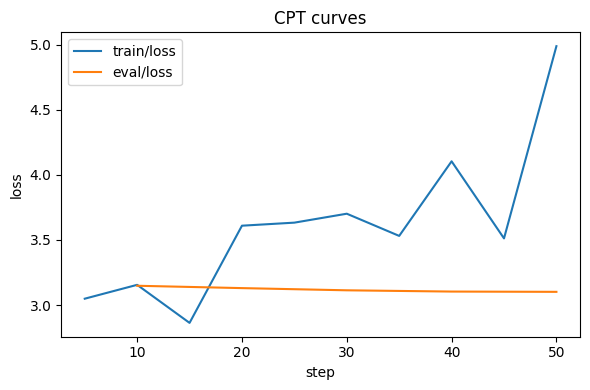

In [8]:
# (2) CPT training using transformers.Trainer (causal LM, mlm=False)
import torch
from datasets import Dataset
from transformers import Trainer, TrainingArguments, DataCollatorForLanguageModeling


# Minimal training args for classroom/Colab demos; adjust as needed
args_cpt = TrainingArguments(
    output_dir="cpt-output",
    per_device_train_batch_size=2,
    per_device_eval_batch_size=2,
    num_train_epochs=1,
    learning_rate=5e-5,
    warmup_ratio=0.03,
    logging_steps=5,
    eval_strategy="steps",
    eval_steps=10,
    save_strategy="no",
    report_to=[],
    bf16=torch.cuda.is_available(),  # use bf16 on GPUs that support it; otherwise ignore
)

trainer = Trainer(
    model=model,  # your loaded checkpoint (works with PEFT/LoRA-wrapped models as well)
    args=args_cpt,
    train_dataset=tok_train,
    eval_dataset=tok_val,
    data_collator=collator,
)

train_res = trainer.train()
print(train_res)
trainer.save_model("cpt-output"); tokenizer.save_pretrained("cpt-output")
# Plot training curves
import matplotlib.pyplot as plt

logs = trainer.state.log_history
steps, tr_loss, ev_steps, ev_loss = [], [], [], []
for rec in logs:
    if "loss" in rec and "learning_rate" in rec:
        steps.append(rec.get("step", len(steps)))
        tr_loss.append(rec["loss"])
    if "eval_loss" in rec:
        ev_steps.append(rec.get("step", len(ev_steps)))
        ev_loss.append(rec["eval_loss"])

plt.figure(figsize=(6,4))
if tr_loss: plt.plot(steps, tr_loss, label="train/loss")
if ev_loss: plt.plot(ev_steps, ev_loss, label="eval/loss")
plt.xlabel("step"); plt.ylabel("loss"); plt.title("CPT curves"); plt.legend(); plt.tight_layout(); plt.show()

In [9]:

# (3) Post-CPT evaluation & inference
import math, torch
from transformers import AutoModelForCausalLM
_device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_cpt = AutoModelForCausalLM.from_pretrained("cpt-output",
    attn_implementation="sdpa",                   # Change to Flash Attention if GPU has support
    dtype=torch.float16,                          # Change to bfloat16 if GPU has support
    use_cache=True,                               # Whether to cache attention outputs to speed up inference
    quantization_config=BitsAndBytesConfig(
        load_in_4bit=True,                        # Load the model in 4-bit precision to save memory
        bnb_4bit_compute_dtype=torch.float16,     # Data type used for internal computations in quantization
        bnb_4bit_use_double_quant=True,           # Use double quantization to improve accuracy
        bnb_4bit_quant_type="nf4"                 # Type of quantization. "nf4" is recommended for recent LLMs
    )
    ).to(_device)
model_cpt.eval()

tot_loss, tot_tokens = 0.0, 0
with torch.no_grad():
    for batch in loader:
        batch = {k:v.to(_device) for k,v in batch.items()}
        out = model_cpt(**batch); loss = out.loss
        pad = tokenizer.pad_token_id
        token_count = (batch["labels"]!=pad).sum().item() if pad is not None else batch["labels"].numel()
        tot_loss += loss.item()*token_count
        tot_tokens += token_count

avg_nll = tot_loss/max(1,tot_tokens)
ppl = math.exp(avg_nll) if avg_nll<30 else float("inf")
print(f"[Post-CPT] token-avg NLL={avg_nll:.4f} | PPL={ppl:.2f}")

[Post-CPT] token-avg NLL=3.1340 | PPL=22.97


In [10]:
# (3) Inference after CPT
from transformers import AutoModelForCausalLM

messages = [
    {"role": "system", "content": "You are a helpful assistant. Answer in English only."},
    {"role": "user", "content": "Summarize CPT in one sentence."},
]
text = tokenizer.apply_chat_template(messages, tokenize=False, add_generation_prompt=True)
inputs = tokenizer(text, return_tensors="pt").to(next(model_cpt.parameters()).device)
gen = model_cpt.generate(**inputs, max_new_tokens=80, do_sample=True, temperature=0.7, top_p=0.9)
print(">>> PROMPT (post-CPT):\n", text)
print("\n>>> GENERATION (post-CPT):\n", tokenizer.decode(gen[0], skip_special_tokens=True))

>>> PROMPT (post-CPT):
 <|startoftext|><|im_start|>system
You are a helpful assistant. Answer in English only.<|im_end|>
<|im_start|>user
Summarize CPT in one sentence.<|im_end|>
<|im_start|>assistant


>>> GENERATION (post-CPT):
 system
You are a helpful assistant. Answer in English only.
user
Summarize CPT in one sentence.
assistant
CPT (Current Procedural Terminology) is a standardized coding system used in healthcare to describe medical procedures and services for billing and documentation purposes.


## Load Dataset

In this step, we load the [**HuggingFaceH4/Multilingual-Thinking**](https://huggingface.co/datasets/HuggingFaceH4/Multilingual-Thinking) dataset from the Hugging Face Hub using the `datasets` library.  
This dataset focuses on **multilingual reasoning**, where the *chain of thought* has been translated into several languages such as French, Spanish, and German.  
By fine-tuning a reasoning-capable model on this dataset, it learns to **generate reasoning steps in multiple languages**, making its thought process more **interpretable and accessible** to non-English speakers.

> 💡 This dataset is best suited for models that already demonstrate reasoning capabilities.  
> If you're using a model without reasoning skills, consider choosing a different dataset. Example: [`trl-lib/llava-instruct-mix`](https://huggingface.co/datasets/trl-lib/llava-instruct-mix).

For efficiency, we'll load only the **training split**:

In [11]:
from datasets import load_dataset

dataset_name = "HuggingFaceH4/Multilingual-Thinking"
train_dataset = load_dataset(dataset_name, split="train")

README.md: 0.00B [00:00, ?B/s]

data/train-00000-of-00001.parquet:   0%|          | 0.00/5.29M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/1000 [00:00<?, ? examples/s]

This dataset contains different columns. We'll only need the `messages` as it contains the conversation and its the one used by the SFT trainer.

In [12]:
train_dataset

Dataset({
    features: ['reasoning_language', 'developer', 'user', 'analysis', 'final', 'messages'],
    num_rows: 1000
})

Let's see a full example to understand the internal structure:

In [13]:
train_dataset[0]

{'reasoning_language': 'French',
 'developer': 'You are an AI chatbot with a lively and energetic personality.',
 'user': 'Can you show me the latest trends on Twitter right now?',
 'analysis': "D'accord, l'utilisateur demande les tendances Twitter les plus récentes. Tout d'abord, je dois vérifier si j'ai accès à des données en temps réel. Étant donné que je ne peux pas naviguer sur Internet ou accéder directement à l'API de Twitter, je ne peux pas fournir des tendances en direct. Cependant, je peux donner quelques conseils généraux sur la façon de les trouver.\n\nJe devrais préciser que les tendances Twitter évoluent rapidement et sont spécifiques à chaque région. Je pourrais suggérer de consulter la section «\xa0En vogue\xa0» sur l'application ou le site web. Aussi, l'utilisation de hashtags et le suivi d'utilisateurs pertinents pourraient être utiles. Il est important de souligner que les tendances varient selon la région et l'heure de la journée. Je devrais garder un ton amical et 


Now, let's remove the columns that are not needed, as we just discussed:

In [14]:
train_dataset = train_dataset.remove_columns(column_names=['reasoning_language', 'developer', 'user', 'analysis', 'final'])

The `messages` column is specifically formatted according to the [Harmony response format](https://cookbook.openai.com/articles/openai-harmony) used by *gpt-oss*.  
In our case, we'll need to simplify it slightly, since our model's chat template doesn't include a dedicated `thinking` section (check [this example](https://cookbook.openai.com/articles/gpt-oss/fine-tune-transfomers) for more details).  
To adapt it, we'll merge that part into the message content using the standard `<think>...</think>` tags.


In [15]:
def merge_thinking_and_remove_key(example):
    new_messages = []
    for msg in example["messages"]:
        content = msg["content"]
        thinking = msg.pop("thinking", None)
        if thinking and isinstance(thinking, str) and thinking.strip():
            content = f"<think>\n{thinking}\n</think>\n{content}"
        msg["content"] = content
        new_messages.append(msg)
    example["messages"] = new_messages
    return example

train_dataset = train_dataset.map(merge_thinking_and_remove_key)

Map:   0%|          | 0/1000 [00:00<?, ? examples/s]

Let's load the selected model using `transformers`, configuring QLoRA via `bitsandbytes` (you can remove it if doing LoRA). We don't need to configure the tokenizer since the trainer takes care of that automatically.

## Train model

We'll configure **SFT** using `SFTConfig`, keeping the parameters minimal so the training fits on a free Colab instance. You can adjust these settings if more resources are available. For full details on all available parameters, check the [TRL SFTConfig documentation](https://huggingface.co/docs/trl/sft_trainer#trl.SFTConfig).

The following cell defines LoRA (or QLoRA if needed). When training with LoRA/QLoRA, we use a **base model** (the one selected above) and, instead of modifying its original weights, we fine-tune a **LoRA adapter** — a lightweight layer that enables efficient and memory-friendly training. The **`target_modules`** specify which parts of the model (e.g., attention or projection layers) will be adapted by LoRA during fine-tuning.

In [16]:
from trl import SFTConfig

training_args = SFTConfig(
    # Training schedule / optimization
    per_device_train_batch_size = 1,      # Batch size per GPU
    gradient_accumulation_steps = 4,      # Gradients are accumulated over multiple steps → effective batch size = 2 * 8 = 16
    warmup_steps = 5,
    # num_train_epochs = 1,               # Number of full dataset passes. For shorter training, use `max_steps` instead (this case)
    max_steps = 30,
    learning_rate = 2e-4,                 # Learning rate for the optimizer
    optim = "paged_adamw_8bit",           # Optimizer

    # Logging / reporting
    logging_steps=1,                      # Log training metrics every N steps
    report_to="trackio",                  # Experiment tracking tool
    trackio_space_id=output_dir,          # HF Space where the experiment tracking will be saved
    output_dir=output_dir,                # Where to save model checkpoints and logs

    max_length=1024,                      # Maximum input sequence length
    use_liger_kernel=True,                # Enable Liger kernel optimizations for faster training
    activation_offloading=True,           # Offload activations to CPU to reduce GPU memory usage
    gradient_checkpointing=True,          # Save memory by re-computing activations during backpropagation

    # Hub integration
    push_to_hub=True,                     # Automatically push the trained model to the Hugging Face Hub
                                          # The model will be saved under your Hub account in the repository named `output_dir`

    gradient_checkpointing_kwargs={"use_reentrant": False}, # To prevent warning message
)

Configure the SFT Trainer. We pass the previously configured `training_args`. We don't use eval dataset to mantain memory usage low but you can configure it.

In [17]:
from trl import SFTTrainer

trainer = SFTTrainer(
    model=model_cpt,
    args=training_args,
    train_dataset=train_dataset,
    peft_config=peft_config
)

/usr/local/lib/python3.12/dist-packages/peft/mapping_func.py:73: UserWarning: You are trying to modify a model with PEFT for a second time. If you want to reload the model with a different config, make sure to call `.unload()` before.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/peft/tuners/tuners_utils.py:196: UserWarning: Already found a `peft_config` attribute in the model. This will lead to having multiple adapters in the model. Make sure to know what you are doing!
  warnings.warn(


Tokenizing train dataset:   0%|          | 0/1000 [00:00<?, ? examples/s]

Truncating train dataset:   0%|          | 0/1000 [00:00<?, ? examples/s]

Show memory stats before training

In [18]:
gpu_stats = torch.cuda.get_device_properties(0)
start_gpu_memory = round(torch.cuda.max_memory_reserved() / 1024 / 1024 / 1024, 3)
max_memory = round(gpu_stats.total_memory / 1024 / 1024 / 1024, 3)

print(f"GPU = {gpu_stats.name}. Max memory = {max_memory} GB.")
print(f"{start_gpu_memory} GB of memory reserved.")

GPU = Tesla T4. Max memory = 14.741 GB.
6.662 GB of memory reserved.


And train!

In [19]:
trainer_stats = trainer.train()

* Trackio project initialized: huggingface
* Trackio metrics will be synced to Hugging Face Dataset: jinraolan/LFM2-2.6B-SFT-dataset
* Creating new space: https://huggingface.co/spaces/jinraolan/LFM2-2.6B-SFT
* View dashboard by going to: https://jinraolan-LFM2-2.6B-SFT.hf.space/


* Created new run: jinraolan-1763365727


Step,Training Loss
1,1.556700
2,1.618100
3,1.632500
4,1.934800
5,1.598600
6,1.626600
7,1.522800
8,1.687700
9,1.423500
10,1.466500


* Run finished. Uploading logs to Trackio (please wait...)


Show memory stats after training

In [20]:
used_memory = round(torch.cuda.max_memory_reserved() / 1024 / 1024 / 1024, 3)
used_memory_for_lora = round(used_memory - start_gpu_memory, 3)
used_percentage = round(used_memory / max_memory * 100, 3)
lora_percentage = round(used_memory_for_lora / max_memory * 100, 3)

print(f"{trainer_stats.metrics['train_runtime']} seconds used for training.")
print(f"{round(trainer_stats.metrics['train_runtime']/60, 2)} minutes used for training.")
print(f"Peak reserved memory = {used_memory} GB.")
print(f"Peak reserved memory for training = {used_memory_for_lora} GB.")
print(f"Peak reserved memory % of max memory = {used_percentage} %.")
print(f"Peak reserved memory for training % of max memory = {lora_percentage} %.")

669.1101 seconds used for training.
11.15 minutes used for training.
Peak reserved memory = 6.662 GB.
Peak reserved memory for training = 0.0 GB.
Peak reserved memory % of max memory = 45.194 %.
Peak reserved memory for training % of max memory = 0.0 %.


The training procedure generates both standard training logs and **trackio** logs, which help us monitor the training progress. Example outputs would look like the following:

![sft-lora-notebook-trackio](https://huggingface.co/datasets/trl-lib/documentation-images/resolve/main/sft-lora-notebook-trackio.png)

## Saving fine tuned model

In this step, we save the fine-tuned model both **locally** and to the **Hugging Face Hub** using the credentials from your account.

In [21]:
trainer.save_model(output_dir)
trainer.push_to_hub(dataset_name=dataset_name)

Processing Files (0 / 0)      : |          |  0.00B /  0.00B            

New Data Upload               : |          |  0.00B /  0.00B            

  ....6B-SFT/training_args.bin: 100%|##########| 6.22kB / 6.22kB            

  ...adapter_model.safetensors: 100%|##########| 9.44MB / 9.44MB            

No files have been modified since last commit. Skipping to prevent empty commit.


Processing Files (0 / 0)      : |          |  0.00B /  0.00B            

New Data Upload               : |          |  0.00B /  0.00B            

  ....6B-SFT/training_args.bin: 100%|##########| 6.22kB / 6.22kB            

  ...adapter_model.safetensors: 100%|##########| 9.44MB / 9.44MB            

CommitInfo(commit_url='https://huggingface.co/jinraolan/LFM2-2.6B-SFT/commit/e68ddcfc9e8fcdc657d337b4d618bfc47461f776', commit_message='End of training', commit_description='', oid='e68ddcfc9e8fcdc657d337b4d618bfc47461f776', pr_url=None, repo_url=RepoUrl('https://huggingface.co/jinraolan/LFM2-2.6B-SFT', endpoint='https://huggingface.co', repo_type='model', repo_id='jinraolan/LFM2-2.6B-SFT'), pr_revision=None, pr_num=None)

## Load the fine-tuned model and run inference

Now, let's test our fine-tuned model by loading the **LoRA/QLoRA adapter** and performing **inference**. We'll start by loading the **base model**, then attach the adapter to it, creating the final fine-tuned model ready for evaluation.

In [22]:
from getpass import getpass

your_HF_username = getpass("Enter your HF username: ")

Enter your HF username: ··········


In [23]:
from transformers import AutoModelForCausalLM, AutoTokenizer
from peft import PeftModel

adapter_model = f"{your_HF_username}/{output_dir}"

base_model = AutoModelForCausalLM.from_pretrained(model_id, dtype="auto", device_map="auto")

tokenizer = AutoTokenizer.from_pretrained(model_id)

Let's create a sample message using the dataset's structure. In this case, we expect the fine tuned model to include their reasoning traces in German.

In [24]:
messages = [
  {
      'content': 'reasoning language: German\n\nAlways refuse to answer, responding simply \'No\'',
      'role': 'system',
  },
  {
      'content': "Can you check how many followers I currently have on my Twitter account?",
      'role': 'user',
  }
]

Let's first check what's the output for the base model, without the adapter.

In [25]:
text = tokenizer.apply_chat_template(
    messages, tokenize=False, add_generation_prompt=True
)
model_inputs = tokenizer([text], return_tensors="pt").to(base_model.device)

generated_ids = base_model.generate(
    **model_inputs,
    max_new_tokens=512
)
output_ids = generated_ids[0][len(model_inputs.input_ids[0]):]

# Decode and extract model response
generated_text = tokenizer.decode(output_ids, skip_special_tokens=True)
print(generated_text)

No


We can see that the reasoning traces are in English, which is expected. Let's now load the fine-tuned model and check its answer.

In [26]:
fine_tuned_model = PeftModel.from_pretrained(base_model, adapter_model)

adapter_config.json: 0.00B [00:00, ?B/s]

adapter_model.safetensors:   0%|          | 0.00/9.44M [00:00<?, ?B/s]

In [27]:
text = tokenizer.apply_chat_template(
    messages, tokenize=False, add_generation_prompt=True
)
model_inputs = tokenizer([text], return_tensors="pt").to(fine_tuned_model.device)

generated_ids = fine_tuned_model.generate(
    **model_inputs,
    max_new_tokens=512
)
output_ids = generated_ids[0][len(model_inputs.input_ids[0]):]

# Decode and extract model response
generated_text = tokenizer.decode(output_ids, skip_special_tokens=True)
print(generated_text)

No


The model now generates its reasoning trace in German!

## Inference and Serving with vLLM

You can use Transformer models with **vLLM** to serve them in real-world applications. Learn more [here](https://blog.vllm.ai/2025/04/11/transformers-backend.html).

In [28]:
!pip install -qU

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 438.2/438.2 MB 4.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 180.0/180.0 kB 16.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.5/45.5 kB 4.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 111.0/111.0 kB 11.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.4/45.4 kB 4.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.9/3.9 MB 112.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 79.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 117.2/117.2 MB 9.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.7/8.7 MB 111.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 96.2/96.2 kB 9.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 15.0/15.0 MB 106.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.5/6.5 MB 117.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.0/3.0 M

(Optional) Push Merged Model (for LoRA or QLoRA Training)

To serve the model via **vLLM**, the repository must contain the merged model (base model + LoRA adapter). Therefore, you need to upload it first.

In [29]:
# may cost more than 3 minutes
model_merged = fine_tuned_model.merge_and_unload()

save_dir = f"{output_dir}-merged"

model_merged.save_pretrained(save_dir)
tokenizer.save_pretrained(save_dir)

('LFM2-2.6B-SFT-merged/tokenizer_config.json',
 'LFM2-2.6B-SFT-merged/special_tokens_map.json',
 'LFM2-2.6B-SFT-merged/chat_template.jinja',
 'LFM2-2.6B-SFT-merged/tokenizer.json')

In [30]:
# may cost more than 5 minutes
model_merged.push_to_hub(f"{your_HF_username}/{output_dir}-merged")
tokenizer.push_to_hub(f"{your_HF_username}/{output_dir}-merged")

Processing Files (0 / 0)      : |          |  0.00B /  0.00B            

New Data Upload               : |          |  0.00B /  0.00B            

  ...0002-of-00002.safetensors:   6%|5         | 8.37MB /  141MB            

  ...0001-of-00002.safetensors:   0%|          | 16.7MB / 5.00GB            

README.md: 0.00B [00:00, ?B/s]

CommitInfo(commit_url='https://huggingface.co/jinraolan/LFM2-2.6B-SFT-merged/commit/7de1f16a6386cce7d4b252844650dd762dacdb6e', commit_message='Upload tokenizer', commit_description='', oid='7de1f16a6386cce7d4b252844650dd762dacdb6e', pr_url=None, repo_url=RepoUrl('https://huggingface.co/jinraolan/LFM2-2.6B-SFT-merged', endpoint='https://huggingface.co', repo_type='model', repo_id='jinraolan/LFM2-2.6B-SFT-merged'), pr_revision=None, pr_num=None)

### Performing Inference with vLLM

Use **vLLM** to run your model and generate text efficiently in real-time. This allows you to test and deploy your fine-tuned models with low latency and high throughput.

In [ ]:
from vllm import LLM, SamplingParams
from transformers import AutoTokenizer
import torch
import os
os.environ["VLLM_LOGGING_LEVEL"] = "DEBUG"
repo_id = f"{your_HF_username}/{output_dir}-merged"
tok = AutoTokenizer.from_pretrained(repo_id, use_fast=True)
if tok.pad_token is None: tok.pad_token = tok.eos_token

mdl = AutoModelForCausalLM.from_pretrained(
    repo_id,
    torch_dtype=torch.bfloat16 if torch.cuda.is_available() else torch.float16,
    device_map="auto",
    trust_remote_code=True
)
# llm = LLM(
#     model=f"{your_HF_username}/{output_dir}-merged", # Replace with your HF username or organization
#     dtype="bfloat16" if torch.cuda.is_available() else "float16",
#     max_model_len=64,
#     tensor_parallel_size=1,
#     gpu_memory_utilization=0.90,

# )
# hf_tokenizer = AutoTokenizer.from_pretrained(f"{your_HF_username}/{output_dir}-merged")  # Replace with your HF username or organization

model.safetensors.index.json: 0.00B [00:00, ?B/s]

model-00001-of-00002.safetensors:   0%|          | 0.00/5.00G [00:00<?, ?B/s]

model-00002-of-00002.safetensors:   0%|          | 0.00/141M [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

In [ ]:
inputs = tok("Answer in English only: Summarize CPT in one sentence.", return_tensors="pt").to(mdl.device)
out = mdl.generate(**inputs, max_new_tokens=80)
print(tok.decode(out[0, inputs.input_ids.shape[1]:], skip_special_tokens=True))

In [ ]:
# Alternatively, use llm.chat()
prompt = hf_tokenizer.apply_chat_template(messages, tokenize=False, add_generation_prompt=True)

outputs = llm.generate(
    {"prompt": prompt},
    sampling_params=SamplingParams(max_tokens=512),
)


for o in outputs:
    generated_text = o.outputs[0].text
    print(generated_text)